##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 梯度提升树（Gradient Boosted Trees）：模型理解

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/estimator/boosted_trees"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/estimator/boosted_trees.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/estimator/boosted_trees.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://www.tensorflow.org/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

对于梯度提升模型（Gradient Boosting model）的端到端演示（end-to-end walkthrough），请查阅[在 Tensorflow 中训练提升树（Boosted Trees）模型](./boosted_trees)。在本教程中，您将：

* 学习到如何对提升树模型（Boosted Trees model）进行*局部解释*和*全局解释*
* 了解到提升树模型在数据集上的表现。

## 如何对提升树模型（Boosted Trees model）进行局部解释和全局解释

局部可解释性指模型的预测在单一样例层面上的理解程度，而全局可解释性指模型作为一个整体的理解能力。这种技术可以帮助使用机器学习的人在模型开发阶段检测偏差（bias）和bug。

对于局部可解释性，您将了解到如何创造并可视化每个实例（per-instance）的贡献度。区别于特征重要性，这种贡献被称为 DFCs（定向特征贡献，directional feature contributions）。

对于全局可解释性，您将学习并可视化基于增益的特征重要性（gain-based feature importances），排列特征重要性（[permutation feature importances](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)）和总DFCs。

## 加载泰坦尼克数据集（titanic）
本教程使用泰坦尼克数据集，旨在已知乘客的性别，年龄和客舱等级等特征的情况下预测的存活率。

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output

# 加载数据集。
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.random.set_seed(123)

有关特征的描述，请参阅之前的教程。

## 创建特征列, 输入函数并训练估算器（estimator）

### 数据预处理

创建特征列，使用原始的数字列和独热编码（one-hot-encoding）分类别建立变量列。

In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # 需要使用独热编码（one-hot-encoding）处理每类特征。
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

### 建立输入管道（pipeline）

使用 API [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) 中的 `from_tensor_slices` 方法建立输入方程来从 Pandas 中直接读取数据。

In [0]:
# 当数据集小的时候，将整个数据集作为一个 batch。
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # 训练时让数据迭代尽可能多次 （n_epochs=None）。
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# 训练并评估输入函数。
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

### 训练模型

In [0]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # 为了得到 DFCs，请设置 center_bias = True。这将强制
  # 模型在使用特征（例如：回归中训练集标签的均值，分类中使
  # 用交叉熵损失函数时的对数几率）前做一个初始预测。
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# 训练模型。
est.train(train_input_fn, max_steps=100)

# 评估。
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

0
accuracy                0.806818
accuracy_baseline       0.625000
auc                     0.866942
auc_precision_recall    0.845483
average_loss            0.421330
global_step           100.000000
label/mean              0.375000
loss                    0.421330
precision               0.755319
prediction/mean         0.385978
recall                  0.717172

出于性能方面的原因，当您的数据是内存数据集时，我们推荐您使用 `boosted_trees_classifier_train_in_memory` 函数。此外，如果您对训练时间没有要求抑或是您的数据集很大且不愿做分布式训练，请使用上面显示的 `tf.estimator.BoostedTrees` API。


当您使用此方法时，请不要对数据分批（batch），而是对整个数据集进行操作。


In [0]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# 在内存中的输入方程请不要对数据分批。
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# 训练模型。
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
print(est.evaluate(eval_input_fn))

{'accuracy_baseline': 0.625, 'loss': 0.41725963, 'auc': 0.86810529, 'label/mean': 0.375, 'average_loss': 0.41725963, 'accuracy': 0.80681819, 'global_step': 153, 'precision': 0.75531918, 'prediction/mean': 0.38610166, 'recall': 0.71717173, 'auc_precision_recall': 0.8542586}


## 模型说明与绘制

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

## 局部可解释性（Local interpretability）
接下来，您将输出定向特征贡献（DFCs）来解释单个预测。输出依据 [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) 和 Saabas 在 [解释随机森林（Interpreting Random Forests）](http://blog.datadive.net/interpreting-random-forests/) 中提出的方法产生（scikit-learn 中随机森林相关的包 [`treeinterpreter`](https://github.com/andosa/treeinterpreter) 使用相同的原理）。使用以下语句输出 DFCs：

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

（注意：此方法为实验版方法，我们在删除 “experimental” 前缀前均可能对其修改。）

In [0]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

In [0]:
# 创建 DFCs 的 Pandas dataframe。
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

count      mean       std  ...       50%       75%       max
age                 264.0 -0.025285  0.085606  ... -0.051290  0.011908  0.466216
sex                 264.0  0.008138  0.108147  ... -0.072698  0.138499  0.197285
class               264.0  0.017317  0.093436  ... -0.044461  0.035060  0.248212
deck                264.0 -0.016094  0.033232  ... -0.026754  0.005053  0.205399
fare                264.0  0.016471  0.089597  ... -0.011403  0.050212  0.229989
embark_town         264.0 -0.007320  0.027672  ... -0.014375 -0.003016  0.068483
n_siblings_spouses  264.0  0.003973  0.027914  ...  0.004825  0.006412  0.138123
parch               264.0  0.001342  0.007995  ...  0.000510  0.002834  0.048722
alone               264.0  0.000000  0.000000  ...  0.000000  0.000000  0.000000

[9 rows x 8 columns]

DFCs 有个不错的特性：贡献和 + 偏差（bias） = 给出样例的预测值。

In [0]:
# DFCs的和 + 偏差（bias） == 可能性
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

为单个乘客绘制 DFCs，绘图时按贡献的方向性对其进行涂色并添加特征的值。

In [0]:
# 绘制模版 :)
def _get_color(value):
    """正的 DFCs 标为绿色，负的为红色。"""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """在图的左侧显示特征的值"""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # 显示前8个特征。
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # 添加特征的值。
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

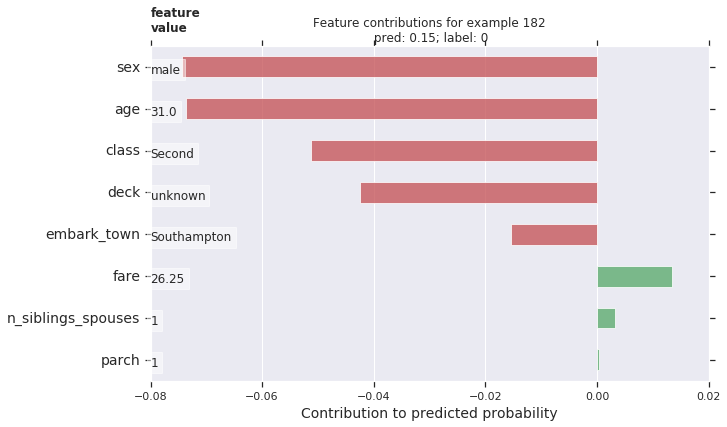

In [0]:
# 绘制结果。
ID = 182
example = df_dfc.iloc[ID]  # 选择第 i 个呀样例作为评估组。
TOP_N = 8  # 显示前8个特征。
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

更大的贡献值意味着对模型的预测有更大的影响。负的贡献表示此样例该特征的值减小了减小了模型的预测，正贡献值表示增加了模型的预测。

您也可以使用小提琴图（violin plot）来绘制该样例的 DFCs 并与整体分布比较。

In [0]:
# 绘制代码模版。
def dist_violin_plot(df_dfc, ID):
  # 初始化画布。
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # 创建样例 dataframe。
  TOP_N = 8  # 显示前8个特征。
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # 添加整个分布的贡献。
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # 添加特征的值。
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # 添加局部贡献。
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # 图例。
  # 生成小提琴图的详细图例。
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # 调整格式。
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

绘制此样例。

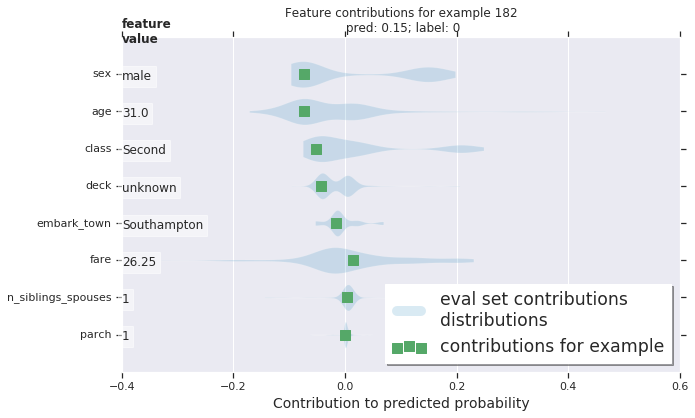

In [0]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

最后，第三方的工具，如：[LIME](https://github.com/marcotcr/lime) 和 [shap](https://github.com/slundberg/shap) 也可以帮助理解模型的各个预测。

## 全局特征重要性（Global feature importances）

此外，您或许想了解模型这个整体而不是单个预测。接下来，您将计算并使用：

* 通过 `est.experimental_feature_importances` 得到基于增益的特征重要性（Gain-based feature importances）
* 排列特征重要性（Permutation feature importances）
* 使用 `est.experimental_predict_with_explanations` 得到总 DFCs。

基于增益的特征重要性在分离特定特征时测量损失的变化。而排列特征重要性是在评估集上通过每次打乱一个特征后观察模型性能的变化计算而出。

一般来说，排列特征重要性要优于基于增益的特征重要性，尽管这两种方法在潜在预测变量的测量范围或类别数量不确定时和特征相关联时不可信（[来源](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)）。 对不同种类特征重要性的更透彻概括和更翔实讨论请参考 [这篇文章](http://explained.ai/rf-importance/index.html) 。

### 基于增益的特征重要性（Gain-based feature importances）

TensorFlow 的提升树估算器（estimator）内置了函数 `est.experimental_feature_importances` 用于计算基于增益的特征重要性。

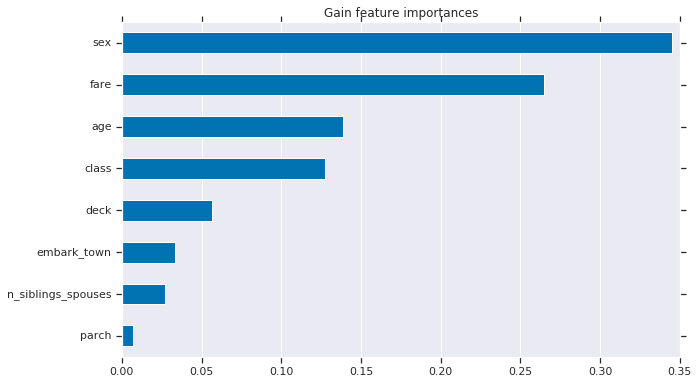

In [0]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# 可视化重要性。
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

### 平均绝对 DFCs
您还可以得到绝对DFCs的平均值来从全局的角度分析影响。

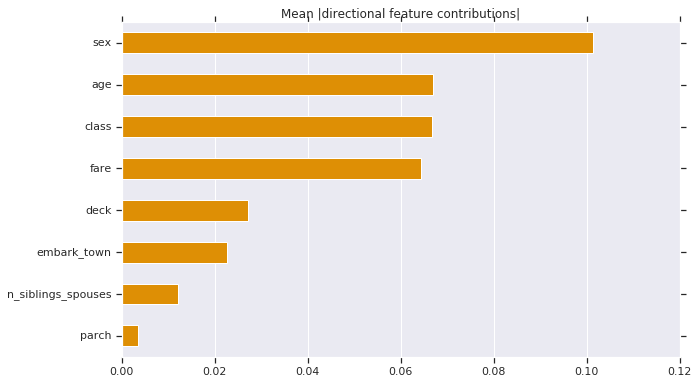

In [0]:
# 绘图。
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # 求平均并按绝对值排序。
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

您可以看到 DFCs 如何随特征的值变化而变化。

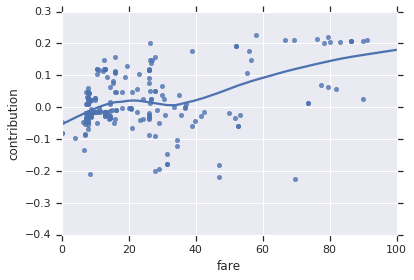

In [0]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

### 排列特征重要性（Permutation feature importances）

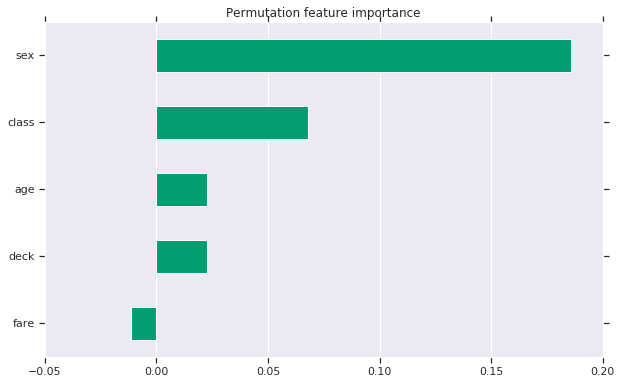

In [0]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """
    分别对每列，打散列中的值并观察其对评估集的影响。
    
    在训练过程中，有一种类似的方法，请参阅文章（来源：http://explained.ai/rf-importance/index.html）
    中有关 “Drop-column importance” 的部分。
    """
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow 估算器精度"""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

## 可视化模型拟合过程

首先，使用以下公式构建训练数据：


$$z=x* e^{-x^2 - y^2}$$


其中， \(z\) 是您要试着预测的值（因变量），\(x\) 和 \(y\) 是特征。

In [0]:
from numpy.random import uniform, seed
from matplotlib.mlab import griddata

# 伪造数据。
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)

In [0]:
# 准备用于训练的数据。
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [0]:
def plot_contour(x, y, z, **kwargs):
  # 网格化数据。
  plt.figure(figsize=(10, 8))
  # 绘制等值线图，标出非均匀数据点。
  CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
  CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
  plt.colorbar()  # 绘制颜色图例。
  # 绘制数据点。
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

您可以可视化这个方程，红色代表较大的值。

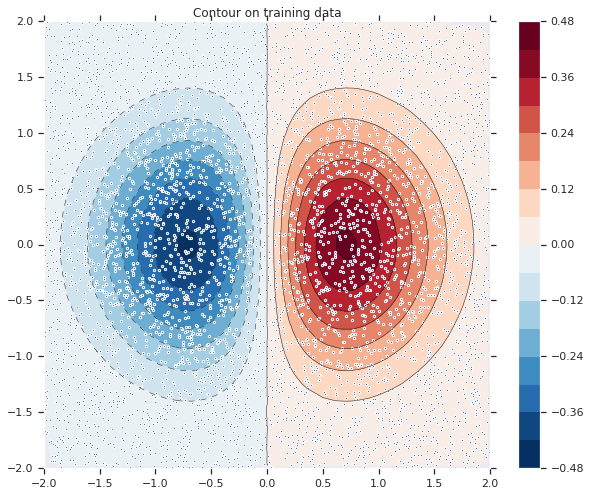

In [0]:
zi = griddata(x, y, z, xi, yi, interp='linear')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [0]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [0]:
def predict(est):
  """已有估算器给出的预测"""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)

首先，我们尝试用线性模型拟合数据。

In [0]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

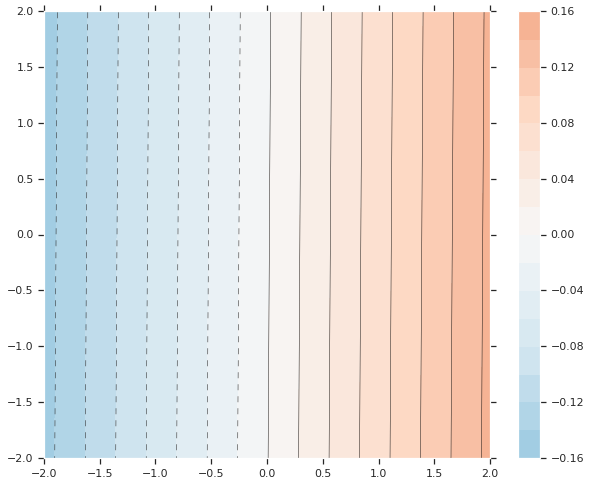

In [0]:
plot_contour(xi, yi, predict(est))

可见，拟合效果并不好。接下来，我们试着用 GBDT 模型拟合并了解模型是如何拟合方程的。

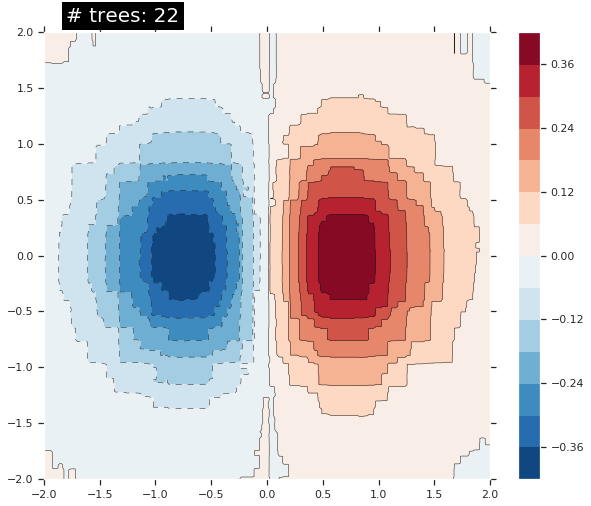

In [0]:
n_trees = 22 #@param {type: "slider", min: 1, max: 80, step: 1}

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()

随着树的数量增加，模型的预测越来越接近真实方程。

![](https://www.tensorflow.org/images/boosted_trees/boosted_trees_ntrees.gif)

## 总结

本文介绍了如何使用定向特征贡献（DFCs）及几种特征重要性来解释提升树模型。这些方法可以帮助您了解特征是如何影响模型的预测。 最后，您还可以通过观察其他模型的超平面（decision surface）并结合本文内容来学习提升树模型是如何拟合方程的。